In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore
from scipy.special import logit
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.neighbors import NearestNeighbors

%run -i 'analysis_utils.py'

100%|██████████| 202/202 [00:03<00:00, 60.61it/s]


In [2]:
chen_comparison, chen_comparison_exons = make_comparison(chen_kw, chen_psix, 'KW_score', 'L_score', bins=20)
song_comparison, song_comparison_exons = make_comparison(song_kw, song_psix, 'KW_score', 'L_score', bins=20)
tiklova_comparison, tiklova_comparison_exons = make_comparison(tiklova_kw, tiklova_psix, 'KW_score', 'L_score', bins=20)

In [3]:
tiklova_cross_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.cross_scores.tab', sep='\t', index_col=0)

In [ ]:
def L_upgma_step(cross_L_matrix, score_min = 0.1):
#     score_min = 0.1
    counter = 1
    for exon in cross_L_matrix.index:
        exon_max = cross_L_matrix.loc[exon].dropna().sort_values().index[-1]
        exon_pair = (exon, exon_max)
        pair_score = cross_L_matrix.loc[exon, exon_max]
        pair_score_r = cross_L_matrix.loc[exon_max, exon]
        if counter == 1:
            max_pair = exon_pair
            max_pair_score = pair_score
            max_pair_score_r = pair_score_r
        else:
            token_1 = (pair_score > max_pair_score) and (pair_score_r >= score_min)
            token_2 = (pair_score >= score_min) and (pair_score_r >= score_min) and (max_pair_score_r < score_min)
            if token_1 or token_2:
                max_pair = (exon, exon_max)
                max_pair_score = cross_L_matrix.loc[exon, exon_max]
                max_pair_score_r = cross_L_matrix.loc[exon_max, exon]
        counter += 1

    if (max_pair_score >= score_min) and (max_pair_score_r >= score_min):
        new_idx = [x for x in cross_L_matrix.index if x not in max_pair]
        new_df = cross_L_matrix.loc[new_idx, new_idx]

        combined_cross_1 = cross_L_matrix.loc[new_idx, list(max_pair)].mean(axis=1)
        combined_cross_2 = cross_L_matrix.loc[list(max_pair), new_idx].mean(axis=0)

        new_df[','.join(max_pair)] = combined_cross_2
        new_df = new_df.T
        new_df[','.join(max_pair)] = list(combined_cross_1) + [0]
        new_df = new_df.T
        
        return new_df
    else:
        print(max_pair_score)
        return [0]
            
            
def get_modules(cross_L_matrix, score_min = 0.0):
    counter = 1
    for i in tqdm(range(len(cross_L_matrix.index))):
        combined_cross = L_upgma_step(cross_L_matrix, score_min)
        if len(combined_cross) == 1:
            return cross_L_matrix
        else:
            cross_L_matrix = combined_cross
            
#         print(counter)
    return cross_L_matrix
        

In [18]:
def L_upgma_step(cross_L_matrix, score_min = 0.1):
#     score_min = 0.1
    counter = 1
    for exon in cross_L_matrix.index:
        exon_max = cross_L_matrix.loc[exon].dropna().sort_values().index[-1]
        exon_pair = (exon, exon_max)
        
        pair_score = cross_L_matrix.loc[exon, exon_max]
        pair_score_r = cross_L_matrix.loc[exon_max, exon]
        
        
        if counter == 1:
            max_pair = exon_pair
            max_pair_score = pair_score
            max_pair_score_r = pair_score_r
        else:
            token_1 = (pair_score > max_pair_score) and (pair_score_r >= score_min)
            token_2 = (pair_score >= score_min) and (pair_score_r >= score_min) and (max_pair_score_r < score_min)
            if token_1 or token_2:
                max_pair = (exon, exon_max)
                max_pair_score = cross_L_matrix.loc[exon, exon_max]
                max_pair_score_r = cross_L_matrix.loc[exon_max, exon]
        counter += 1

    if (max_pair_score >= score_min) and (max_pair_score_r >= score_min):
        new_idx = [x for x in cross_L_matrix.index if x not in max_pair]
        new_df = cross_L_matrix.loc[new_idx, new_idx]
        
        weight_exon_1 = int(max_pair[0].split(':')[1])
        weight_exon_2 = int(max_pair[1].split(':')[1])
        
        combined_cross_1_1 = cross_L_matrix.loc[new_idx, max_pair[0]]*weight_exon_1
        combined_cross_1_2 = cross_L_matrix.loc[new_idx, max_pair[1]]*weight_exon_2
        combined_cross_1 = (combined_cross_1_1 + combined_cross_1_2)/(weight_exon_1 + weight_exon_2)
        
        combined_cross_2_1 = cross_L_matrix.loc[max_pair[0], new_idx]*weight_exon_1
        combined_cross_2_2 = cross_L_matrix.loc[max_pair[1], new_idx]*weight_exon_2
        combined_cross_2 = (combined_cross_2_1 + combined_cross_2_2)/(weight_exon_1 + weight_exon_2)
        
#         combined_cross_1 = cross_L_matrix.loc[new_idx, list(max_pair)].mean(axis=1)
#         combined_cross_2 = cross_L_matrix.loc[list(max_pair), new_idx].mean(axis=0)
        new_name = max_pair[0].split(':')[0] + ',' + max_pair[1].split(':')[0] + ':' + str(weight_exon_1+weight_exon_2)
        
        new_df[new_name] = combined_cross_2
        new_df = new_df.T
        new_df[new_name] = list(combined_cross_1) + [0]
        new_df = new_df.T
        
        return new_df
    else:
        print(max_pair_score)
        return [0]
            
            
def get_modules(cross_L_matrix, score_min = 0.0):
    idx = [x+':1' for x in cross_L_matrix.index]
    cross_L_matrix.index = idx
    cross_L_matrix.columns = idx
    counter = 1
    for i in tqdm(range(len(cross_L_matrix.index))):
        combined_cross = L_upgma_step(cross_L_matrix, score_min)
        if len(combined_cross) == 1:
            return cross_L_matrix
        else:
            cross_L_matrix = combined_cross
            
#         print(counter)
    return cross_L_matrix
        

In [4]:
def L_upgma_step(cross_L_matrix, score_min = 0.1):
#     score_min = 0.1
    counter = 1
    for exon in cross_L_matrix.index:
        exon_max = cross_L_matrix.loc[exon].dropna().sort_values().index[-1]
        exon_pair = (exon, exon_max)
        pair_score = cross_L_matrix.loc[exon, exon_max]
        pair_score_r = cross_L_matrix.loc[exon_max, exon]
        if counter == 1:
            max_pair = exon_pair
            max_pair_score = pair_score
            max_pair_score_r = pair_score_r
        else:
            token_1 = (pair_score > max_pair_score) and (pair_score_r >= score_min)
            token_2 = (pair_score >= score_min) and (pair_score_r >= score_min) and (max_pair_score_r < score_min)
            if token_1 or token_2:
                max_pair = (exon, exon_max)
                max_pair_score = cross_L_matrix.loc[exon, exon_max]
                max_pair_score_r = cross_L_matrix.loc[exon_max, exon]
        counter += 1

    if (max_pair_score >= score_min) and (max_pair_score_r >= score_min):
        new_idx = [x for x in cross_L_matrix.index if x not in max_pair]
        new_df = cross_L_matrix.loc[new_idx, new_idx]

        combined_cross_1 = cross_L_matrix.loc[new_idx, list(max_pair)].mean(axis=1)
        combined_cross_2 = cross_L_matrix.loc[list(max_pair), new_idx].mean(axis=0)

        new_df[','.join(max_pair)] = combined_cross_2
        new_df = new_df.T
        new_df[','.join(max_pair)] = list(combined_cross_1) + [0]
        new_df = new_df.T
        
        return new_df
    else:
        print(max_pair_score)
        return [0]
            
            
def get_modules(cross_L_matrix, score_min = 0.0):
    counter = 1
    for i in tqdm(range(len(cross_L_matrix.index))):
        combined_cross = L_upgma_step(cross_L_matrix, score_min)
        if len(combined_cross) == 1:
            return cross_L_matrix
        else:
            cross_L_matrix = combined_cross
            
#         print(counter)
    return cross_L_matrix
        

In [31]:
modules_psix = get_modules(tiklova_cross_psix)

 90%|████████▉ | 669/745 [20:48<02:21,  1.87s/it]

0.0275


In [4]:
# modules_psix.to_csv('tiklova_modules.tab', sep='\t', index=True, header=True)
modules_psix = pd.read_csv('tiklova_modules.tab', sep='\t', index_col=0)
modules_psix_2 = pd.read_csv('modules.tab', sep='\t', index_col=0)

In [11]:
tiklova_cross_psix

Agrn_8  Arfip2_nmdSE_1  Bclaf1_1  Camta1_5  Ccdc136_17  \
Agrn_8           0.012          -0.022     0.015     0.068      -0.004   
Arfip2_nmdSE_1  -0.046           0.008    -0.028    -0.024      -0.023   
Bclaf1_1         0.010          -0.016     0.014    -0.089      -0.017   
Camta1_5         0.026          -0.027    -0.012     0.018       0.045   
Ccdc136_17       0.013          -0.005     0.010    -0.118       0.016   
...                ...             ...       ...       ...         ...   
Mapt_1           0.041          -0.051     0.068     0.071       0.155   
Meg3_2           0.003           0.001     0.006    -0.085       0.017   
Nnat_2           0.017           0.008     0.020    -0.040       0.008   
Nnat_3           0.016           0.007     0.021    -0.031       0.008   
Nnat_6           0.043          -0.001     0.041    -0.002      -0.005   

                Chtf8_3  Clip1_11  Dhcr7_5  Dlg4_3  Ece2_4  ...  Tecr_6  \
Agrn_8            0.005     0.023    0.010  -0.002   0.008  ...  -0.036   
Arfip2_nmdSE_1   -0.019    -0.024   -0.027  -0.033  -0.012  ...  -0.000   
Bclaf1_1          0.012     0.004    0.017   0.007   0.011  ...  -0.045   
Camta1_5         -0.042    -0.024    0.027  -0.006  -0.067  ...  -0.004   
Ccdc136_17        0.004    -0.003   -0.018  -0.033  -0.015  ...  -0.056   
...                 ...       ...      ...     ...     ...  ...     ...   
Mapt_1            0.074     0.051    0.044   0.112   0.142  ...   0.049   
Meg3_2            0.006     0.004    0.002   0.001  -0.004  ...   0.099   
Nnat_2            0.011     0.004    0.012  -0.013  -0.016  ...   0.208   
Nnat_3            0.010     0.004    0.011  -0.013  -0.016  ...   0.193   
Nnat_6            0.035     0.025    0.033   0.002   0.009  ...  -0.033   

                Cadm1_10  Cadm1_4  Ncam1_6  Ndrg4_1  Mapt_1  Meg3_2  Nnat_2  \
Agrn_8            -0.048   -0.003   -0.172   -0.214  -0.213  -0.027  -0.046   
Arfip2_nmdSE_1    -0.035   -0.028   -0.145   -0.229  -0.268  -0.006  -0.018   
Bclaf1_1          -0.075   -0.042   -0.205   -0.299  -0.308  -0.022  -0.076   
Camta1_5          -0.217   -0.027   -0.013   -0.079  -0.111  -0.005  -0.019   
Ccdc136_17        -0.128   -0.004   -0.066   -0.105  -0.114  -0.046  -0.091   
...                  ...      ...      ...      ...     ...     ...     ...   
Mapt_1            -0.172    0.061    0.527    0.846   0.994   0.019   0.040   
Meg3_2             0.047   -0.123   -0.310   -0.415  -0.273   0.134   0.129   
Nnat_2             0.029   -0.115   -0.253   -0.443  -0.385   0.205   0.276   
Nnat_3             0.029   -0.097   -0.224   -0.409  -0.377   0.177   0.244   
Nnat_6             0.027    0.027   -0.072   -0.171  -0.193  -0.027  -0.025   

                Nnat_3  Nnat_6  
Agrn_8          -0.048  -0.051  
Arfip2_nmdSE_1  -0.016  -0.030  
Bclaf1_1        -0.078  -0.088  
Camta1_5        -0.019  -0.029  
Ccdc136_17      -0.087  -0.095  
...                ...     ...  
Mapt_1           0.037   0.000  
Meg3_2           0.134   0.043  
Nnat_2           0.275   0.030  
Nnat_3           0.248   0.047  
Nnat_6          -0.016   0.209  

[745 rows x 745 columns]

In [5]:
idx = [x.split(':')[0] for x in modules_psix_2]
modules_psix_2.index = idx
modules_psix_2.columns = idx

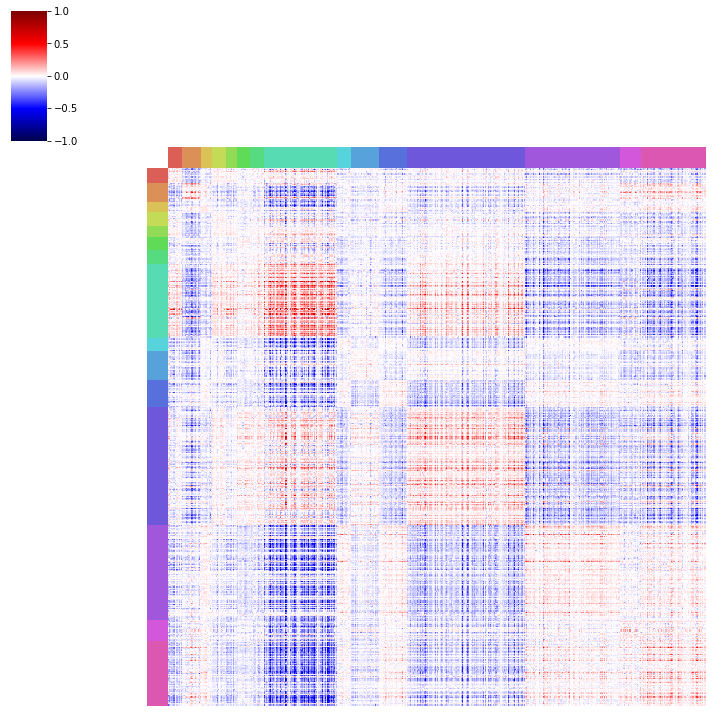

In [6]:
# css_out = get_modules(cross_super_sig, 0.01)
clusters = {}
counter = 0
for cluster in modules_psix.index:
    list_to_add = sorted(set(cluster.split(',')))
    if len(list_to_add) >= 10:
        clusters.update({counter:list_to_add})
        counter += 1
        
        
exons_list = []
for i in range(len(clusters.keys())):
# for i in [4, 0, 2, 3, 5, 1]:
    exons_list.extend(clusters[i])
    
colores = sns.color_palette("hls", 16)
exons_list = []
color_list = []
for i in range(len(clusters.keys())):
# for i in [5, 3, 0, 2, 6, 4, 1]:
# for i in [13, 1, 8, 14, 2, 10, 12, 9, 6, 5, 4, 3, 0, 11, 7]:
    exons_list.extend(clusters[i])
    color_list.extend([colores[i]]*len(clusters[i]))
    
sns.clustermap(tiklova_cross_psix.loc[exons_list, exons_list], col_cluster=False, row_cluster=False,
               col_colors=color_list, row_colors = color_list, cmap='seismic', vmin=-1, vmax=1,
              yticklabels=0, xticklabels=0)

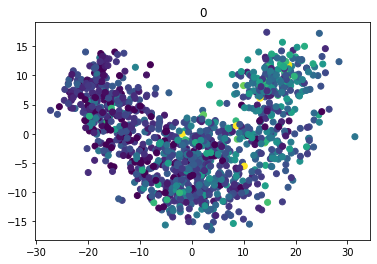

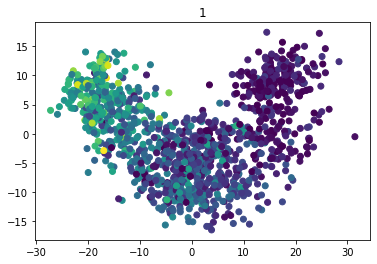

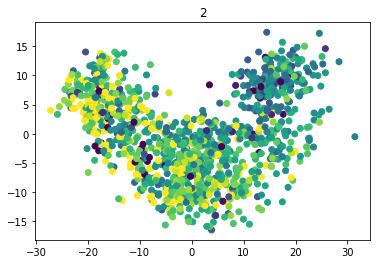

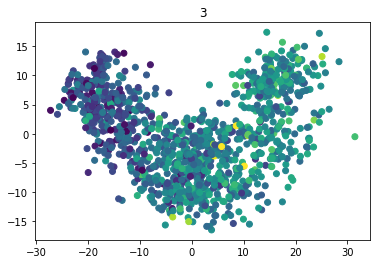

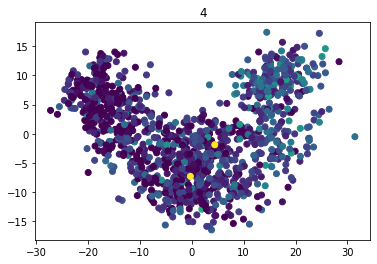

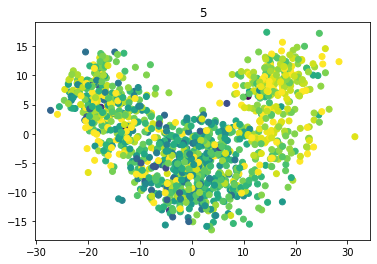

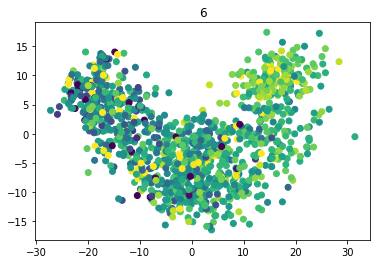

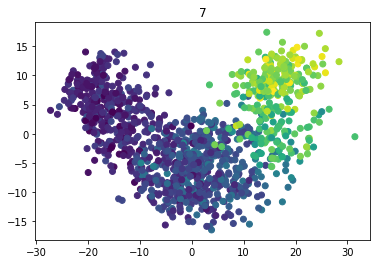

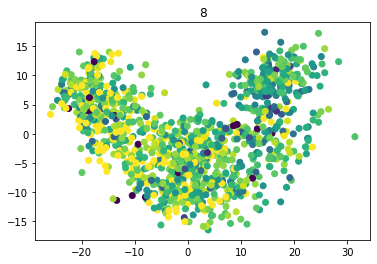

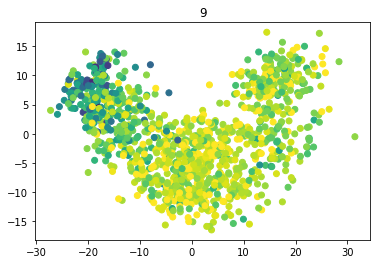

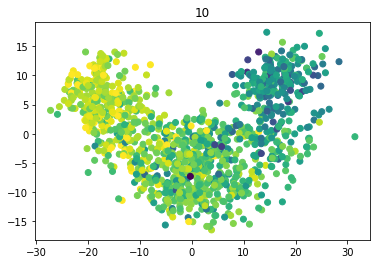

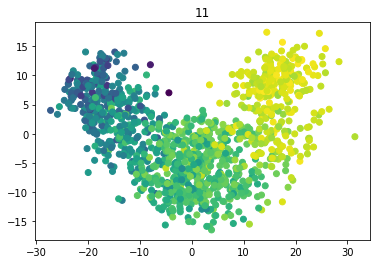

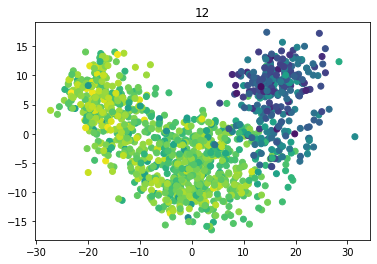

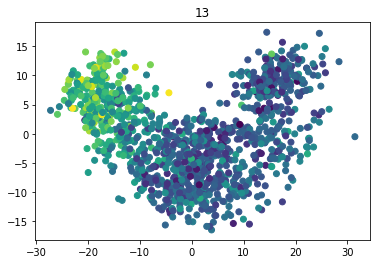

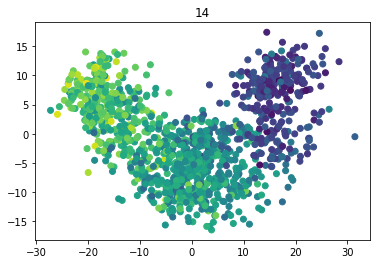

In [7]:
for i in clusters.keys():
    plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, 
                c = tiklova_PSI.loc[clusters[i]].mean(axis=0))
    plt.title(i)
    plt.show()

In [8]:
pseudotime = pd.read_csv('~/data_sc_regulation/tiklova/pseudotime.tab', sep='\t', index_col=0)
ordered_cells = pseudotime.loc[tiklova_rd.index].lineage_1_pseudotime.dropna().sort_values().index

In [45]:
def cluster_pseudotime(cluster, psi_table, pseudotime, window=10):
    order = pseudotime.loc[psi_table.columns].sort_values('lineage_1_pseudotime').lineage_1_pseudotime.dropna()
    cells = order.index
    exon_df = pd.DataFrame()
    
    counter = 1
    
    for exon in tqdm(cluster):
        exon_avg = []
        if counter == 1:
            pseudotime_avg = []
        for i in range(len(order)-window+1):
            cell_slice = cells[i:i+window]
            
            exon_avg.append(psi_table.loc[exon, cell_slice].mean())
            
            if counter == 1:
            
                pseudotime_avg.append(order.loc[cell_slice].mean())
                
        counter += 1
            
        exon_df[exon] = exon_avg
        
    return exon_df, pseudotime_avg
        

100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


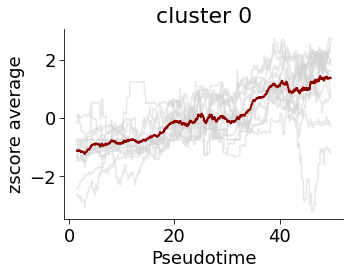

100%|██████████| 18/18 [00:33<00:00,  1.88s/it]


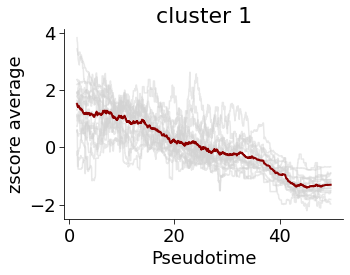

100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


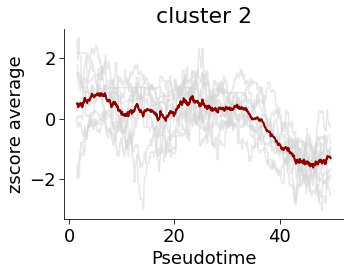

100%|██████████| 13/13 [00:23<00:00,  1.79s/it]


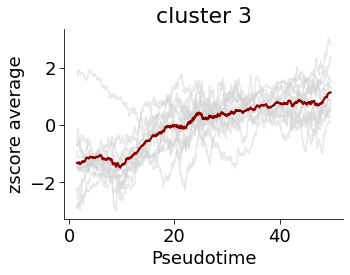

100%|██████████| 11/11 [00:22<00:00,  2.05s/it]


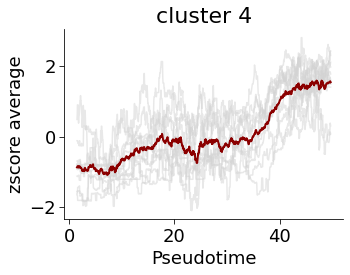

100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


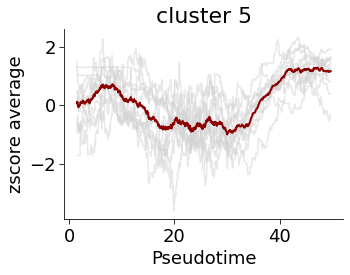

100%|██████████| 13/13 [00:25<00:00,  1.93s/it]


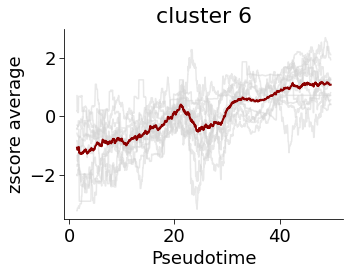

100%|██████████| 70/70 [02:06<00:00,  1.81s/it]


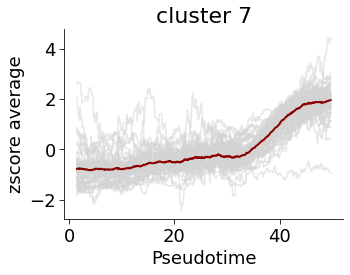

100%|██████████| 13/13 [00:25<00:00,  1.95s/it]


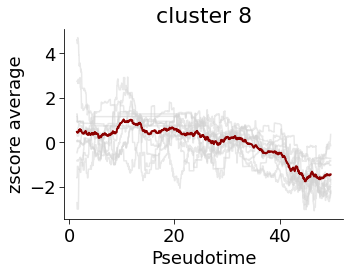

100%|██████████| 27/27 [00:49<00:00,  1.84s/it]


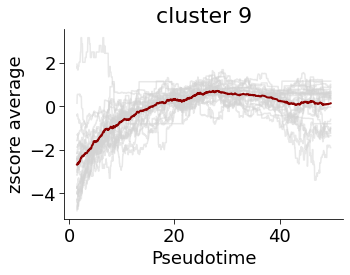

100%|██████████| 26/26 [00:48<00:00,  1.85s/it]


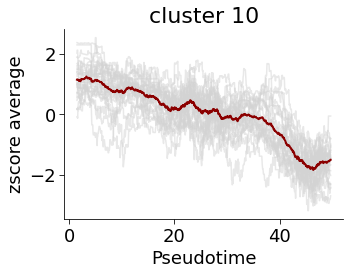

100%|██████████| 112/112 [03:06<00:00,  1.66s/it]


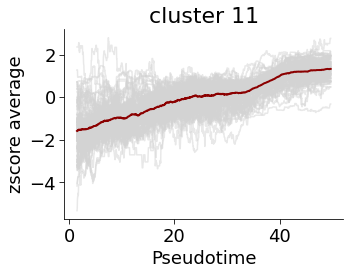

100%|██████████| 90/90 [02:30<00:00,  1.67s/it]


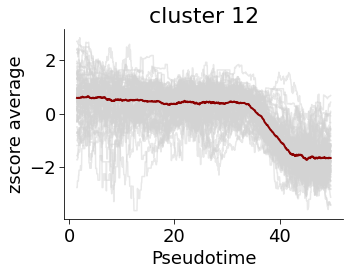

100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


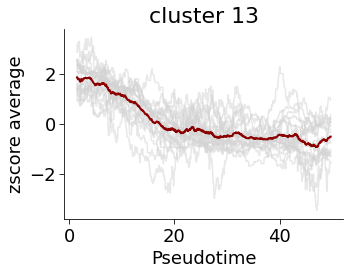

100%|██████████| 61/61 [01:54<00:00,  1.88s/it]


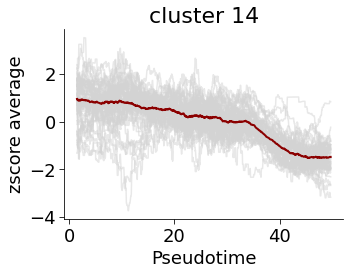

In [47]:
for cluster in clusters.keys():
    
    figsize(5,3.5)
    fig = plt.figure()
    ax  = plt.subplot(1,1,1)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    cluster_df, pseudotime_avg = cluster_pseudotime(clusters[cluster], tiklova_PSI, pseudotime, window=100)
    zscore_avg = pd.DataFrame()
    for exon in cluster_df.columns:
        ax.plot(pseudotime_avg, zscore(cluster_df[exon]), c='lightgray', alpha=0.5)
        zscore_avg[exon] = zscore(cluster_df[exon])
        
    ax.plot(pseudotime_avg, zscore_avg.mean(axis=1), c='darkred', linewidth=2)
    
    
    ax.tick_params(labelsize=18, length=5)

    plt.xlabel('Pseudotime', fontsize=18)
    plt.ylabel('zscore average', fontsize=18)
    plt.title('cluster '+str(cluster), fontsize=22)


    plt.show()
    

In [29]:
clusters

{0: ['Atxn7l1_2',
  'Clasp1_3',
  'Ddx39_nmdSE_1',
  'Dync1i2_4',
  'Limk2_2',
  'Macf1_11',
  'Macf1_12',
  'Mvd_1',
  'Patz1_3',
  'Patz1_4',
  'Prpf40a_nmdSE_2',
  'Rars_2',
  'Sars_5',
  'Zfp280d_14'],
 1: ['Atp6v1h_5',
  'Cadm1_2',
  'Cadm2_1',
  'Chl1_4',
  'Gtf2h1_3',
  'Kctd17_3',
  'Krit1_nmdSE_1',
  'Ktn1_13',
  'Map4_15',
  'Morf4l2_7',
  'Ndufs1_13',
  'Ndufs1_7',
  'Ntan1_1',
  'Ntm_3',
  'Peg3_nmdSE_1',
  'Rsrp1_2',
  'Wiz_nmdSE_1',
  'Zc3h14_11'],
 2: ['Camsap3_5',
  'Dnm2_5',
  'Fbxw11_5',
  'Ncdn_1',
  'Ntan1_6',
  'Pde9a_6',
  'Rpain_1',
  'Slc25a33_1',
  'Tpm3_2',
  'Zfp846_1'],
 3: ['Aplp2_2',
  'Atf2_8',
  'Csnk1a1_3',
  'Hnrnpdl_nmdSE_1',
  'Iqsec3_3',
  'Itsn1_1',
  'Ktn1_17',
  'Meg3_9',
  'Ncam1_4',
  'Pak3_7',
  'Srsf10_nmdSE_1',
  'Srsf2_1',
  'Tk2_2'],
 4: ['Adgrb2_3',
  'Eef1d_10',
  'Emc8_13',
  'Hnrnpll_nmdSE_1',
  'Kansl1_3',
  'Mpg_nmdSE_1',
  'Ndrg3_6',
  'Rbm39_nmdSE_6',
  'Snrpb_nmdSE_1',
  'Zcrb1_nmdSE_1',
  'Zfand6_5'],
 5: ['Cuta_1',
  'Gfra4_1',


In [24]:
order = pseudotime.loc[tiklova_rd.index].sort_values('lineage_1_pseudotime').lineage_1_pseudotime.dropna()
cells = order.index
for i in range(len(order)-29):
    print(len(cells[i:i+30]))

30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
3

In [27]:
order.loc[['SRR7408755', 'SRR7408522']].mean()

0.0

In [48]:
tiklova_PSI_corr = tiklova_PSI.loc[exons_list].T.corr()

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


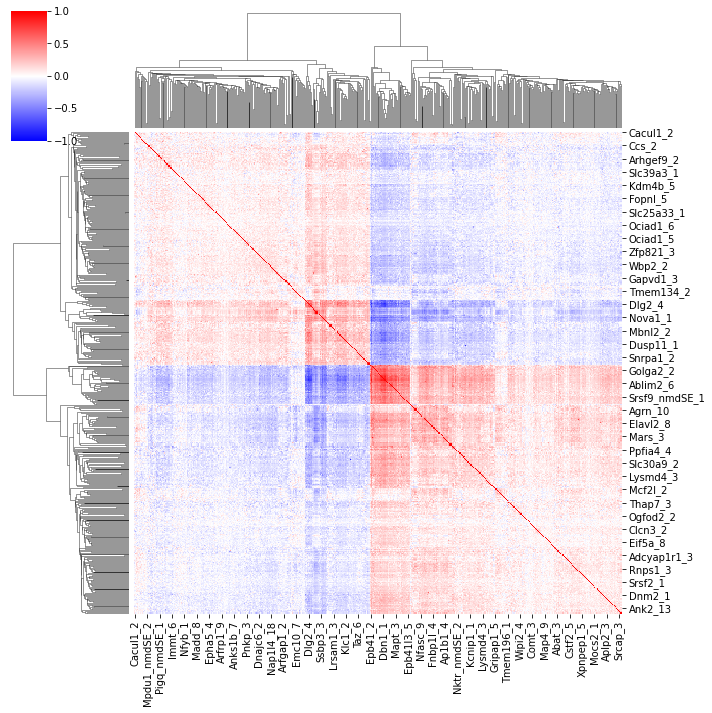

In [49]:
sns.clustermap(tiklova_PSI_corr.fillna(0), cmap='bwr', vmin=-1, vmax=1)

In [50]:
from sklearn.cluster import AgglomerativeClustering as AC

In [54]:
# clusters_corr = AC(n_clusters=15).fit_predict(tiklova_PSI_corr.fillna(0))
clusters_corr = AC(n_clusters=15).fit_predict(tiklova_PSI_corr.fillna(0))
clusters_corr_dict = {}
for i in range(15):
    clusters_corr_dict.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})

100%|██████████| 44/44 [01:22<00:00,  1.88s/it]


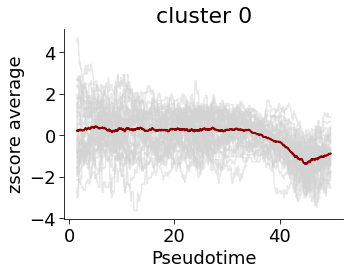

100%|██████████| 29/29 [00:56<00:00,  1.94s/it]


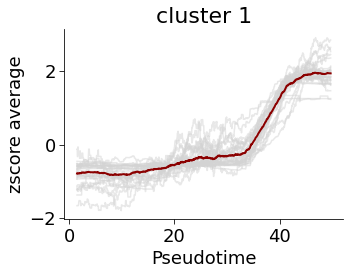

100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


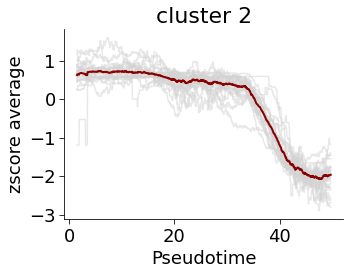

100%|██████████| 51/51 [01:39<00:00,  1.95s/it]


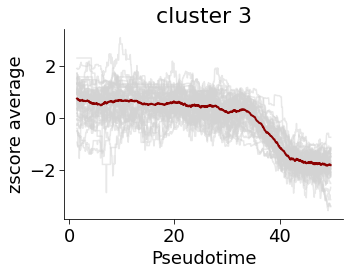

100%|██████████| 34/34 [01:04<00:00,  1.89s/it]


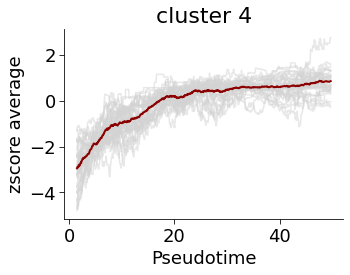

100%|██████████| 28/28 [00:53<00:00,  1.91s/it]


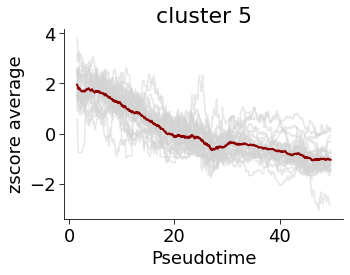

100%|██████████| 36/36 [01:09<00:00,  1.92s/it]


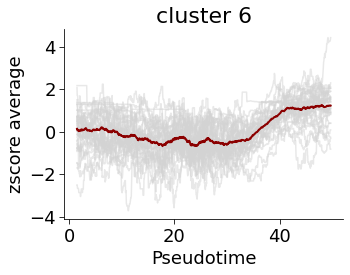

100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


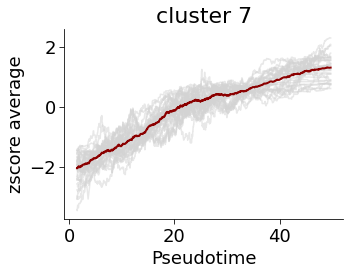

100%|██████████| 40/40 [01:14<00:00,  1.85s/it]


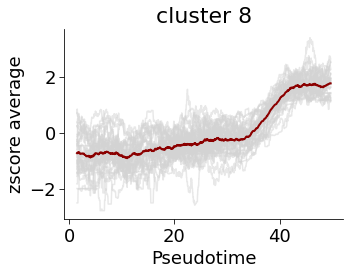

100%|██████████| 31/31 [00:57<00:00,  1.86s/it]


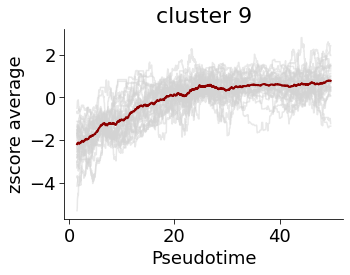

100%|██████████| 9/9 [00:18<00:00,  2.03s/it]


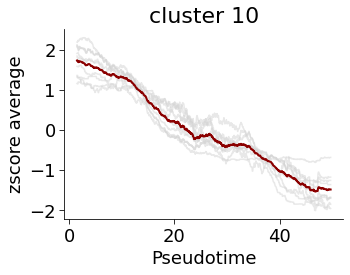

100%|██████████| 67/67 [02:05<00:00,  1.87s/it]


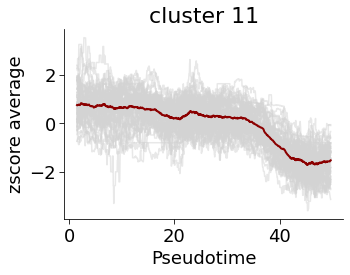

100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


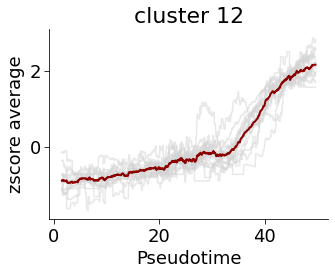

100%|██████████| 51/51 [01:35<00:00,  1.87s/it]


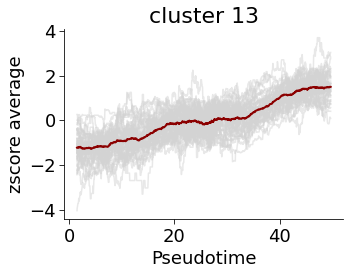

100%|██████████| 18/18 [00:35<00:00,  2.00s/it]


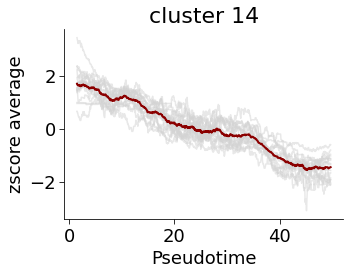

In [56]:
for cluster in clusters_corr_dict.keys():
    
    figsize(5,3.5)
    fig = plt.figure()
    ax  = plt.subplot(1,1,1)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    cluster_df, pseudotime_avg = cluster_pseudotime(clusters_corr_dict[cluster], tiklova_PSI, pseudotime, window=100)
    zscore_avg = pd.DataFrame()
    for exon in cluster_df.columns:
        ax.plot(pseudotime_avg, zscore(cluster_df[exon]), c='lightgray', alpha=0.5)
        zscore_avg[exon] = zscore(cluster_df[exon])
        
    ax.plot(pseudotime_avg, zscore_avg.mean(axis=1), c='darkred', linewidth=2)
    
    
    ax.tick_params(labelsize=18, length=5)

    plt.xlabel('Pseudotime', fontsize=18)
    plt.ylabel('zscore average', fontsize=18)
    plt.title('cluster '+str(cluster), fontsize=22)


    plt.show()
    

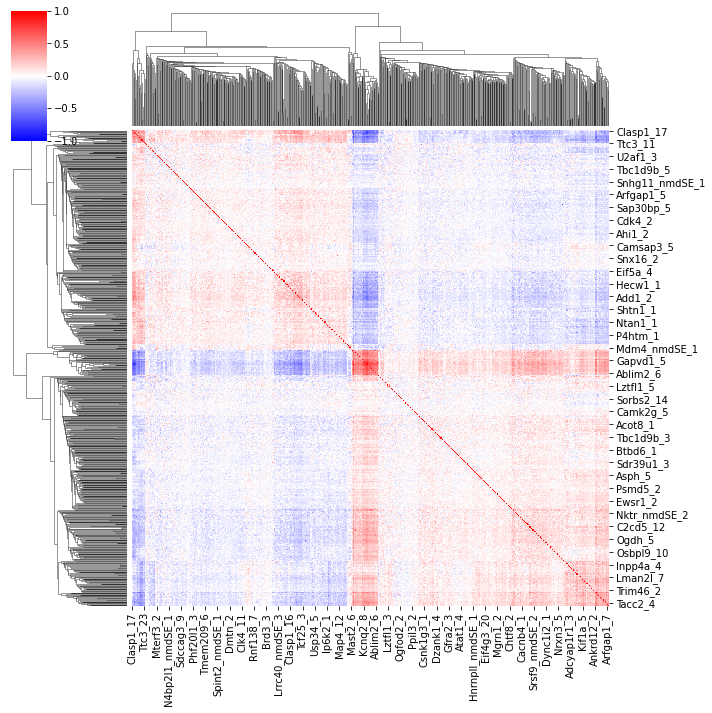

In [32]:
tiklova_PSI_corr = tiklova_PSI.loc[tiklova_cross_psix.index].T.corr()
sns.clustermap(tiklova_PSI_corr.fillna(0), cmap='bwr', vmin=-1, vmax=1)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


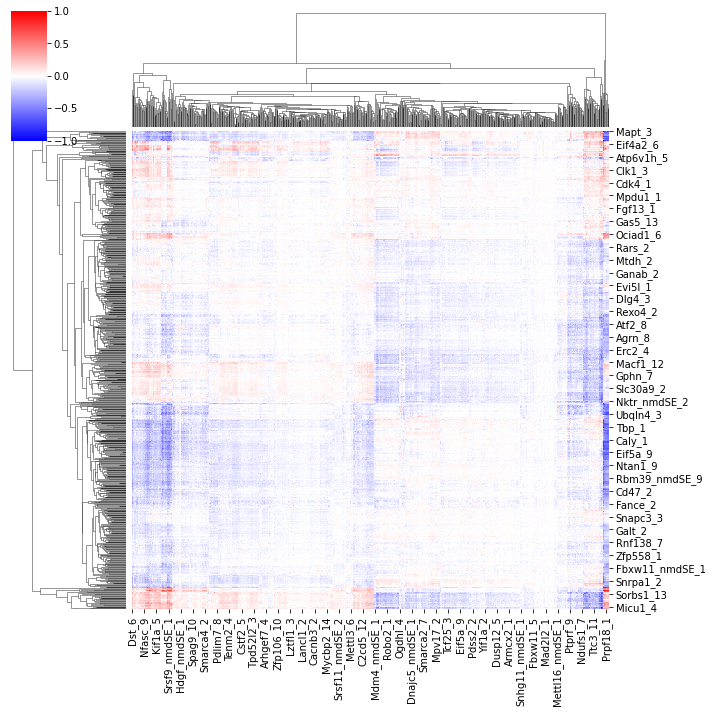

In [31]:
sns.clustermap(tiklova_cross_psix, vmax=1, vmin=-1, cmap='bwr')

100%|██████████| 55/55 [02:00<00:00,  2.19s/it]


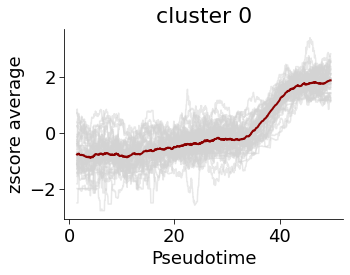

100%|██████████| 82/82 [02:48<00:00,  2.06s/it]


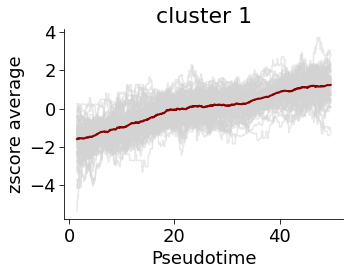

100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


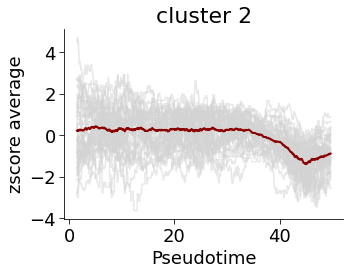

100%|██████████| 46/46 [01:34<00:00,  2.06s/it]


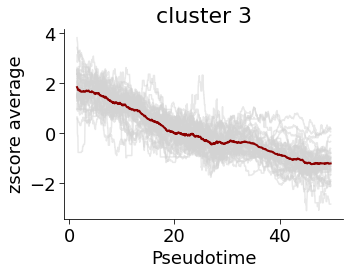

100%|██████████| 29/29 [00:59<00:00,  2.04s/it]


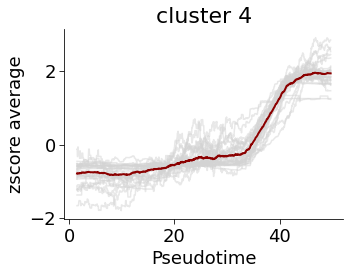

100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


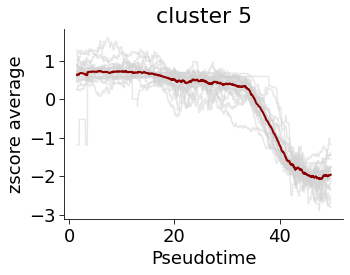

100%|██████████| 36/36 [01:18<00:00,  2.17s/it]


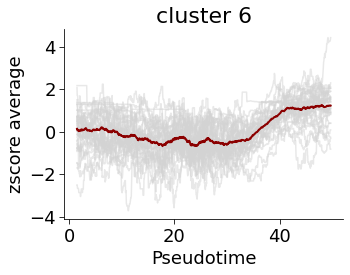

100%|██████████| 32/32 [01:04<00:00,  2.02s/it]


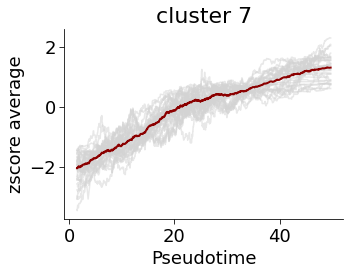

100%|██████████| 51/51 [01:43<00:00,  2.03s/it]


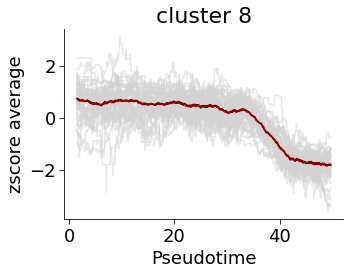

100%|██████████| 34/34 [01:15<00:00,  2.23s/it]


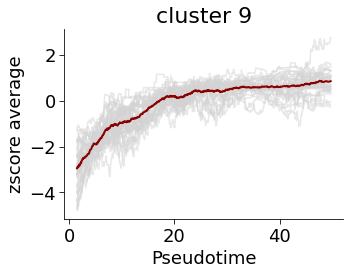

100%|██████████| 9/9 [00:18<00:00,  2.10s/it]


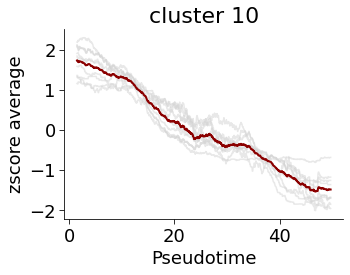

100%|██████████| 67/67 [02:18<00:00,  2.07s/it]


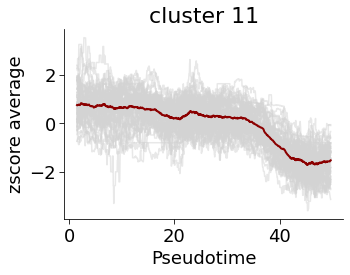

In [60]:
clusters_corr = AC(n_clusters=12).fit_predict(tiklova_PSI_corr.fillna(0))
clusters_corr_dict = {}
for i in range(12):
    clusters_corr_dict.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})
    
    
zscore_table = pd.DataFrame()
    
for cluster in clusters_corr_dict.keys():
    
    figsize(5,3.5)
    fig = plt.figure()
    ax  = plt.subplot(1,1,1)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    cluster_df, pseudotime_avg = cluster_pseudotime(clusters_corr_dict[cluster], tiklova_PSI, pseudotime, window=100)
    zscore_avg = pd.DataFrame()
    for exon in cluster_df.columns:
        ax.plot(pseudotime_avg, zscore(cluster_df[exon]), c='lightgray', alpha=0.5)
        zscore_avg[exon] = zscore(cluster_df[exon])
        
    ax.plot(pseudotime_avg, zscore_avg.mean(axis=1), c='darkred', linewidth=2)
    
    
    ax.tick_params(labelsize=18, length=5)

    plt.xlabel('Pseudotime', fontsize=18)
    plt.ylabel('zscore average', fontsize=18)
    plt.title('cluster '+str(cluster), fontsize=22)


    plt.show()
    
    zscore_table = pd.concat([zscore_table, zscore_avg], axis=1, sort=False)
    

100%|██████████| 116/116 [03:30<00:00,  1.82s/it]


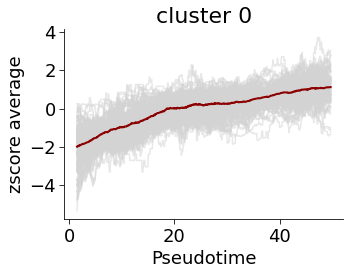

100%|██████████| 34/34 [00:55<00:00,  1.65s/it]


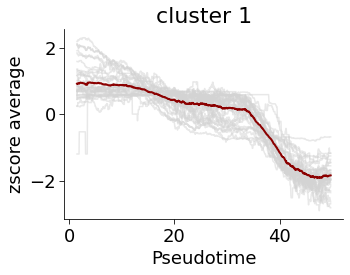

100%|██████████| 111/111 [03:15<00:00,  1.77s/it]


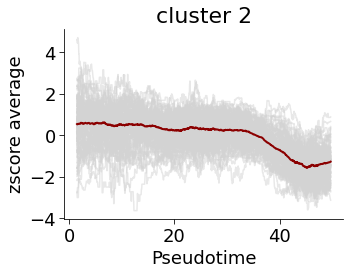

100%|██████████| 46/46 [01:22<00:00,  1.79s/it]


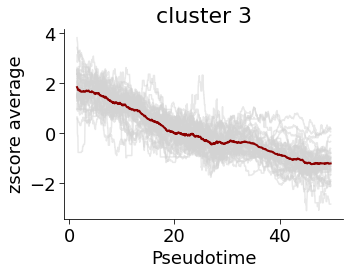

100%|██████████| 29/29 [00:52<00:00,  1.83s/it]


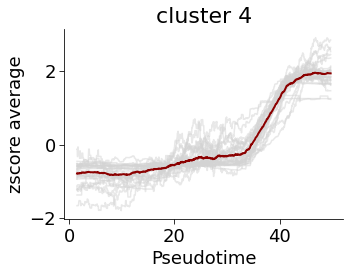

100%|██████████| 55/55 [01:36<00:00,  1.75s/it]


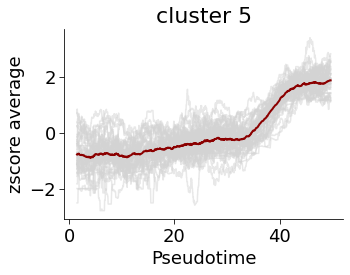

100%|██████████| 36/36 [01:04<00:00,  1.79s/it]


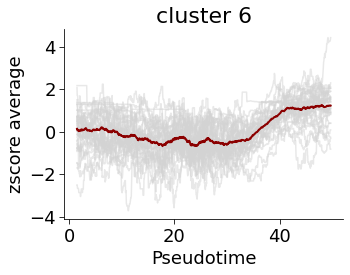

100%|██████████| 32/32 [00:56<00:00,  1.77s/it]


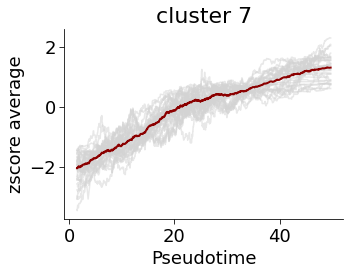

100%|██████████| 51/51 [01:29<00:00,  1.76s/it]


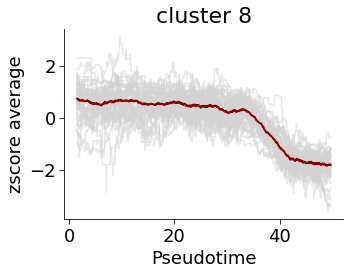

In [57]:
clusters_corr = AC(n_clusters=9).fit_predict(tiklova_PSI_corr.fillna(0))
clusters_corr_dict = {}
for i in range(9):
    clusters_corr_dict.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})
    
    
zscore_table = pd.DataFrame()
    
for cluster in clusters_corr_dict.keys():
    
    figsize(5,3.5)
    fig = plt.figure()
    ax  = plt.subplot(1,1,1)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    cluster_df, pseudotime_avg = cluster_pseudotime(clusters_corr_dict[cluster], tiklova_PSI, pseudotime, window=100)
    zscore_avg = pd.DataFrame()
    for exon in cluster_df.columns:
        ax.plot(pseudotime_avg, zscore(cluster_df[exon]), c='lightgray', alpha=0.5)
        zscore_avg[exon] = zscore(cluster_df[exon])
        
    ax.plot(pseudotime_avg, zscore_avg.mean(axis=1), c='darkred', linewidth=2)
    
    
    ax.tick_params(labelsize=18, length=5)

    plt.xlabel('Pseudotime', fontsize=18)
    plt.ylabel('zscore average', fontsize=18)
    plt.title('cluster '+str(cluster), fontsize=22)


    plt.show()
    
    zscore_table = pd.concat([zscore_table, zscore_avg], axis=1, sort=False)
    

100%|██████████| 108/108 [03:05<00:00,  1.71s/it]


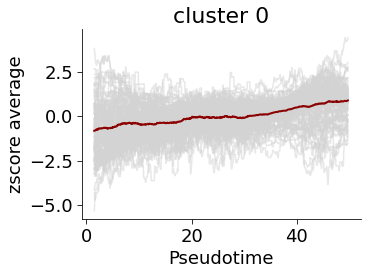

100%|██████████| 191/191 [05:34<00:00,  1.75s/it]


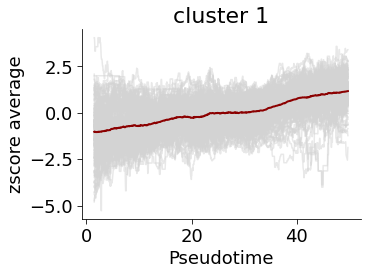

100%|██████████| 168/168 [04:51<00:00,  1.74s/it]


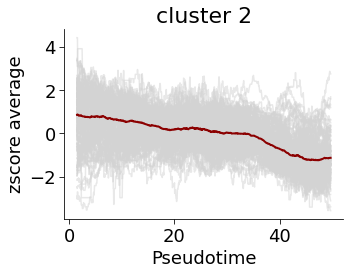

100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


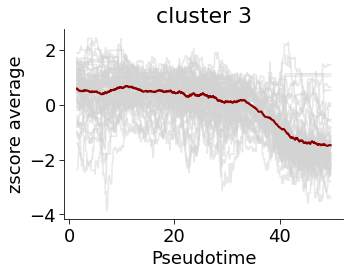

100%|██████████| 85/85 [02:34<00:00,  1.82s/it]


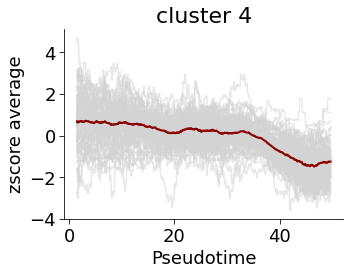

100%|██████████| 68/68 [02:01<00:00,  1.78s/it]


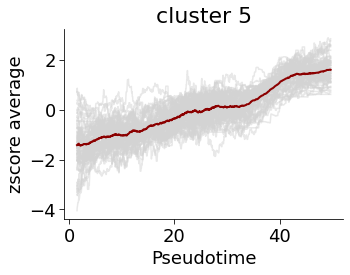

100%|██████████| 39/39 [01:07<00:00,  1.73s/it]


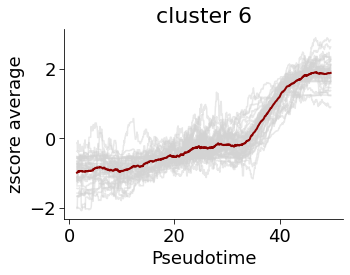

100%|██████████| 18/18 [00:31<00:00,  1.77s/it]


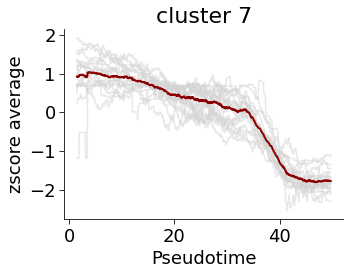

100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


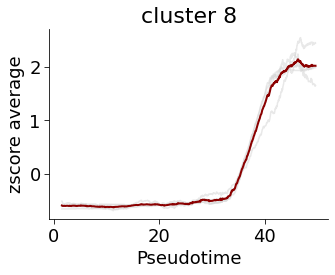

In [58]:
clusters_psix = AC(n_clusters=9).fit_predict(tiklova_cross_psix.fillna(0))
clusters_psix_dict = {}
for i in range(9):
    clusters_psix_dict.update({i:tiklova_cross_psix.loc[clusters_psix == i].index})
    
    
for cluster in clusters_psix_dict.keys():
    
    figsize(5,3.5)
    fig = plt.figure()
    ax  = plt.subplot(1,1,1)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    cluster_df, pseudotime_avg = cluster_pseudotime(clusters_psix_dict[cluster], tiklova_PSI, pseudotime, window=100)
    zscore_avg = pd.DataFrame()
    for exon in cluster_df.columns:
        ax.plot(pseudotime_avg, zscore(cluster_df[exon]), c='lightgray', alpha=0.5)
        zscore_avg[exon] = zscore(cluster_df[exon])
        
    ax.plot(pseudotime_avg, zscore_avg.mean(axis=1), c='darkred', linewidth=2)
    
    
    ax.tick_params(labelsize=18, length=5)

    plt.xlabel('Pseudotime', fontsize=18)
    plt.ylabel('zscore average', fontsize=18)
    plt.title('cluster '+str(cluster), fontsize=22)


    plt.show()
    

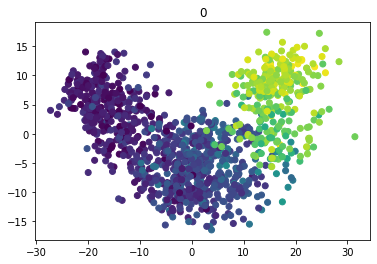

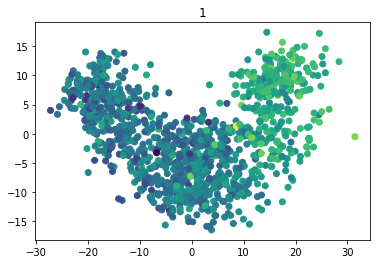

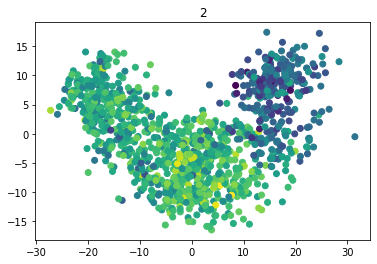

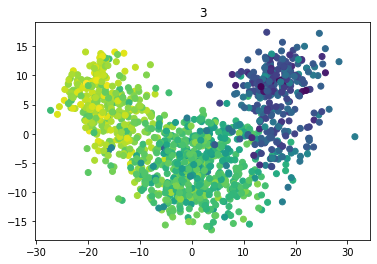

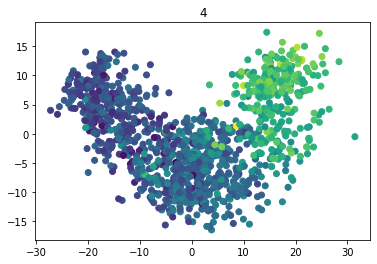

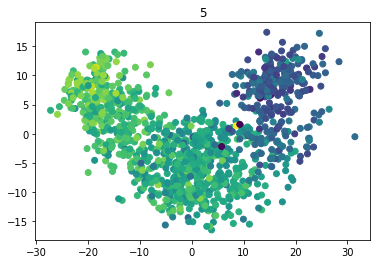

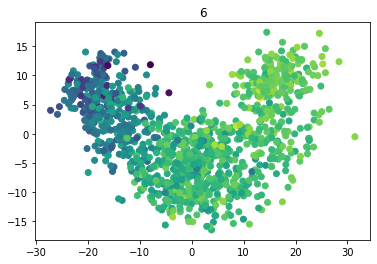

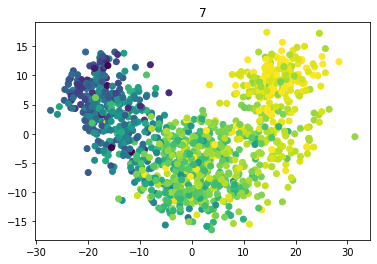

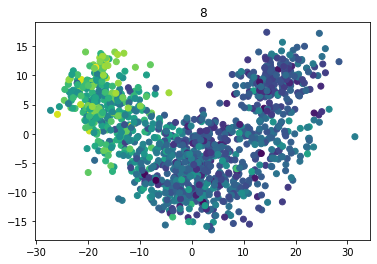

In [35]:
for i in clusters_corr_dict.keys():
    plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, 
                c = tiklova_PSI.loc[clusters_corr_dict[i]].mean(axis=0))
    plt.title(i)
    plt.show()

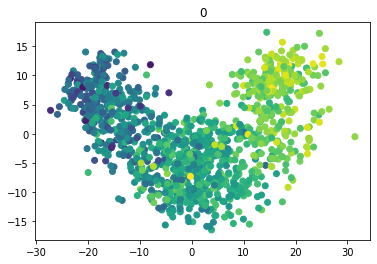

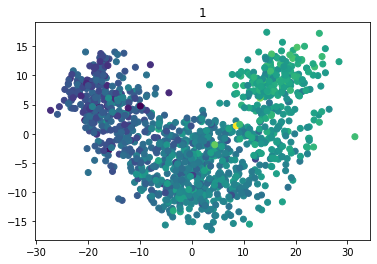

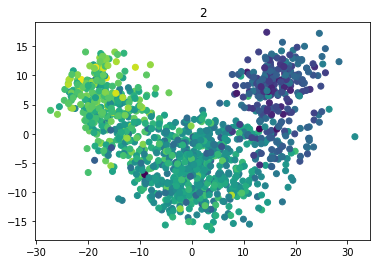

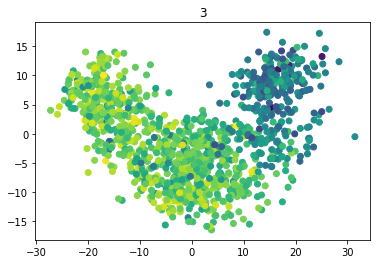

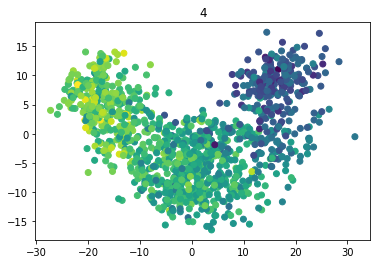

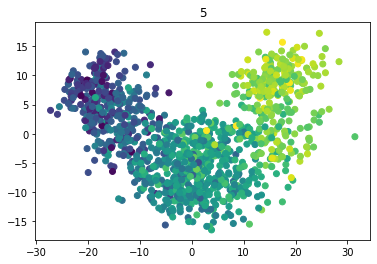

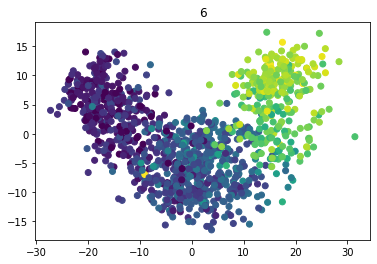

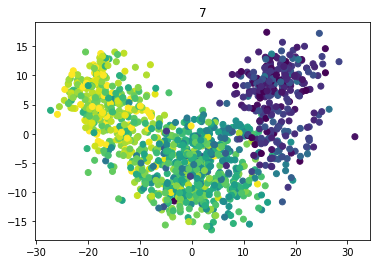

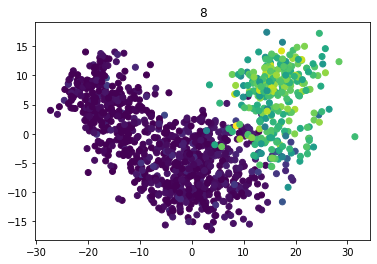

In [36]:
for i in clusters_psix_dict.keys():
    plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, 
                c = tiklova_PSI.loc[clusters_psix_dict[i]].mean(axis=0))
    plt.title(i)
    plt.show()

In [37]:
confusion = pd.DataFrame(np.zeros((6, 6)))
for i in range(6):
    for j in range(6):
        corr_i = clusters_corr_dict[i]
        clust_j = clusters_psix_dict[j]
        shared = len([x for x in corr_i if x in clust_j])
        confusion.loc[i, j] += shared
        #confusion.loc[j, i] = shared

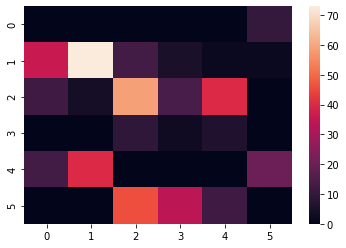

In [39]:
sns.heatmap(confusion)

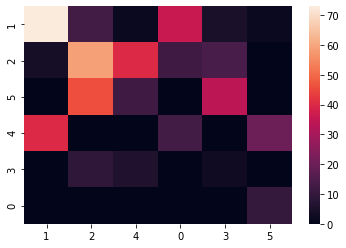

In [47]:
sns.heatmap(confusion.loc[[1, 2, 5, 4, 3, 0], 
                          [1, 2, 4, 0, 3, 5]])

In [67]:
significant_tiklova_psix = tiklova_psix.loc[(tiklova_psix.qvals <= 0.05) & (tiklova_psix.L_score > 0)].index
shared_exons = significant_tiklova_psix & weyn_psi.index

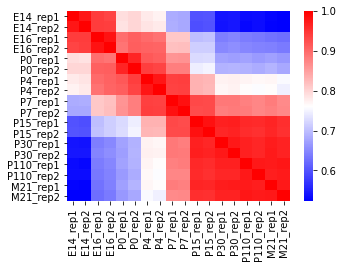

In [72]:
sns.heatmap(weyn_psi.loc[shared_exons].corr(), cmap='bwr')

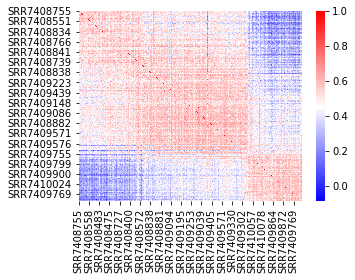

In [75]:
sns.heatmap(tiklova_PSI.loc[shared_exons, ordered_cells].corr(), cmap='bwr')

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


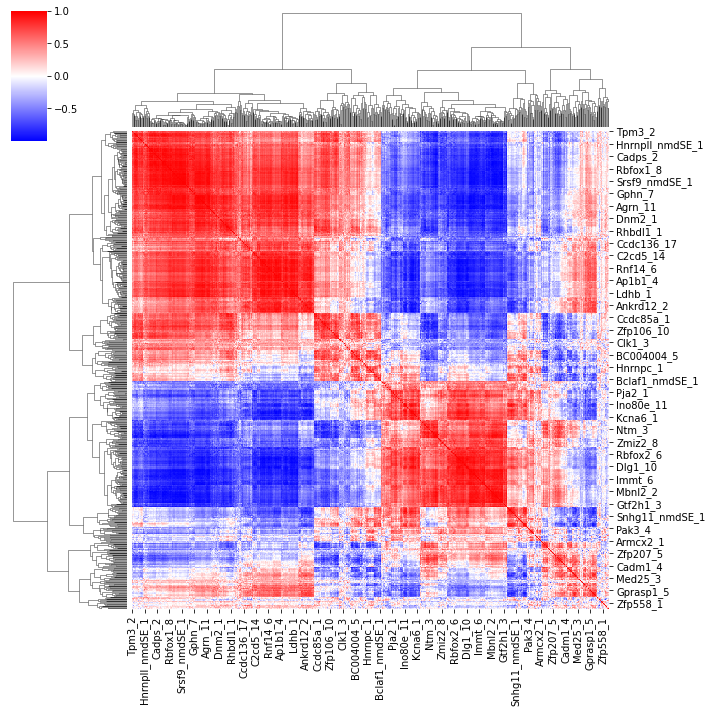

In [77]:
sns.clustermap(weyn_psi.loc[shared_exons].T.corr(), cmap='bwr')

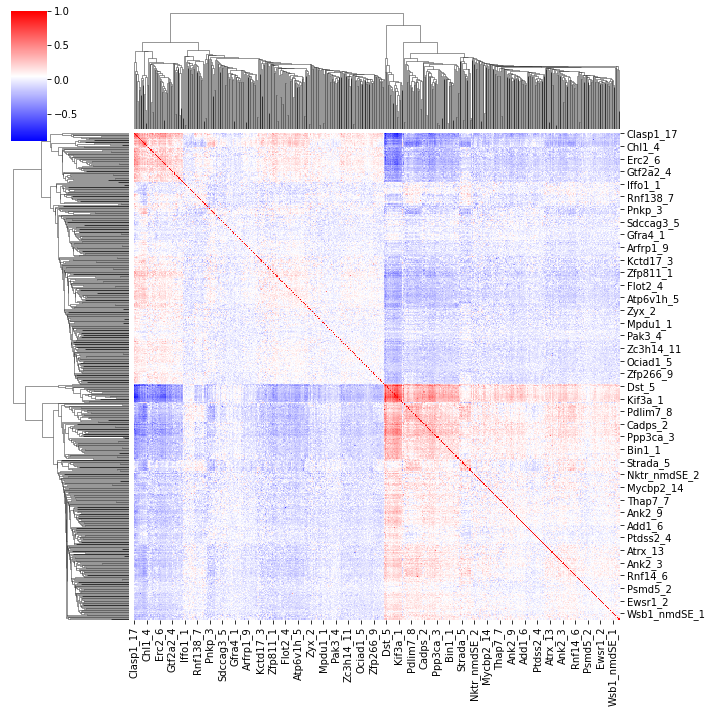

In [79]:
sns.clustermap(tiklova_PSI.loc[shared_exons, ordered_cells].T.corr().fillna(0), cmap='bwr')

In [ ]:
tiklova_PSI_corr = tiklova_PSI.loc[shared_exons].T.corr()


clusters_corr = AC(n_clusters=9).fit_predict(tiklova_PSI_corr.fillna(0))
clusters_corr_dict = {}
for i in range(9):
    clusters_corr_dict.update({i:tiklova_PSI_corr.loc[clusters_corr == i].index})
    
    